<a href="https://colab.research.google.com/github/gamana29/Coding/blob/main/Equalizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

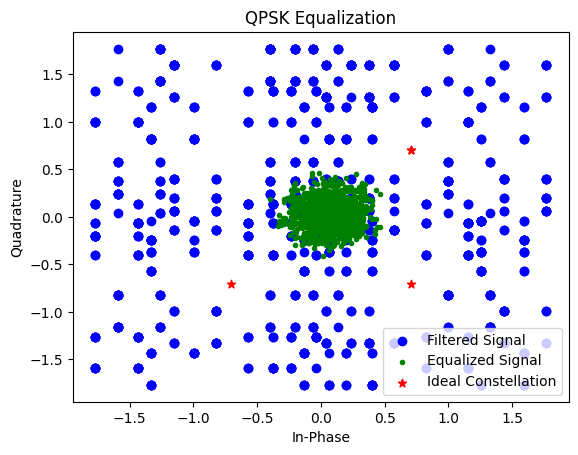

ValueError: operands could not be broadcast together with shapes (992,) (1000,) 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from sklearn.linear_model import SGDRegressor

# Parameters
M = 4  # No. of symbols in the modulated waveform
Nb = 1500  # No. of bits
msg = np.random.randint(0, M, Nb)  # Random message

# QPSK Modulation
phase_offset = 0
modmsg = np.exp(1j * (np.pi / 4 + (np.pi / 2) * msg))

# Channel coefficients
chan = np.array([0.986, 0.845, 0.237, 0.123 + 0.31j])

# Introduce channel distortion
filtmsg = lfilter(chan, 1, modmsg)

# Equalization (LMS Approximation using SGDRegressor)
trainlen = 500
num_taps = 8
step_size = 0.01

X_train = np.array([filtmsg[i : i + num_taps] for i in range(trainlen - num_taps)])
y_train = modmsg[num_taps:trainlen]

equalizer = SGDRegressor(max_iter=1000, eta0=step_size, learning_rate='constant')
equalizer.fit(np.real(X_train), np.real(y_train))
equalizer.fit(np.imag(X_train), np.imag(y_train))

X_test = np.array([filtmsg[i : i + num_taps] for i in range(trainlen, len(filtmsg) - num_taps)])
symbolest = equalizer.predict(np.real(X_test)) + 1j * equalizer.predict(np.imag(X_test))

# Plot scatterplots
plt.figure()
plt.scatter(np.real(filtmsg[trainlen:]), np.imag(filtmsg[trainlen:]), c='b', label='Filtered Signal')
plt.scatter(np.real(symbolest), np.imag(symbolest), c='g', marker='.', label='Equalized Signal')
plt.scatter(np.real(modmsg[:M]), np.imag(modmsg[:M]), c='r', marker='*', label='Ideal Constellation')
plt.legend()
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.title('QPSK Equalization')
plt.show()

# Demodulation
angles_noeq = np.angle(filtmsg[trainlen:])
angles_eq = np.angle(symbolest)
demodmsg_noeq = np.round((angles_noeq - np.pi / 4) / (np.pi / 2)) % M
demodmsg = np.round((angles_eq - np.pi / 4) / (np.pi / 2)) % M

# Error rate calculation
error_noeq = np.mean(demodmsg_noeq != msg[trainlen:])
error_eq = np.mean(demodmsg != msg[trainlen:])

print("Symbol Error rates with and without Equalizer:")
print(f"With Equalizer: {error_eq}")
print(f"Without Equalizer: {error_noeq}")